# Binned likelihood shape fit example
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

### (1) Read input data

In [2]:
# Nevt = 100
# infile = "http://hep.fuw.edu.pl/u/zarnecki/saed23/11_example_data_"+str(Nevt)+".dat"

# Old data (as shown in lecture slides)

Nevt = 100
infile = "http://hep.fuw.edu.pl/u/zarnecki/saed22/10_example_data_"+str(Nevt)+".dat"


ttab = np.loadtxt(infile)

In [3]:
# Create  histogram

tmax = 100.
Nbin = 20

counts, bins = np.histogram(ttab,range=[0,tmax],bins=Nbin)

xvec = bins[:Nbin] + bins[1]/2.
yvec = counts


### (2) Define fit model

In [4]:
# Measurement range

tmax = 100

# Declare normalization factor outside function scope (!)

norm = 1

# Exponential decay + uniform background

def myfun(x,par):

    global norm
    
    # decay time
    
    tdec = par[0]
    
    # Decay fraction
    
    fdec = par[1]

    # Exponential probability distribution
    
    val = fdec/tdec * np.exp(-x/tdec)

    # Add constant term
    
    val += (1-fdec)/tmax
    
    # Normalize to the data
    
    norm = np.sum(yvec)/np.sum(val)

    return norm*val

# Full model: returns values and derivatives

def myfunder(x,par):

    global norm
    
    # output arrays
    
    val = np.zeros(x.size)
    der = np.zeros((x.size,2))

    # decay time
    
    tdec = par[0]
    
    # Decay fraction
    
    fdec = par[1]

    # Exponential probability distribution
    
    val = 1/tdec * np.exp(-x/tdec)

    # with background include
    
    valbg = fdec*val+(1-fdec)/tmax
    
    # derivatives (without normalisation yet)
    
    der[:,0] = fdec*val*(x-tdec)/tdec/tdec
    
    der[:,1] = val-1./tmax
    
    # Normalization factor 
    
    norm = np.sum(yvec)/np.sum(valbg)
    
    val = norm*valbg

    der[:,0] = norm*der[:,0] - norm*valbg/np.sum(valbg)*np.sum(der[:,0])
    der[:,1] = norm*der[:,1] - norm*valbg/np.sum(valbg)*np.sum(der[:,1])
   
    return val,der


### (3) Iterative fit

In [5]:
# Number of function parameters to consider  (fixed for this model)

Nfun = 2

# Initial guess for parameters

parini = np.zeros(Nfun)
parini[0] = 2.
parini[1] = 0.9

# Initial function vales

# fini,dini = myfunder(xvec,parini) 
fini = myfun(xvec,parini) 

# Initial printout

loglini = np.sum(yvec*np.log(fini)-fini)

print("\nIterative fit procedure starting from parameter values")
print(" ",parini)
print("  LL = %8.3f   LL/Ndf = %8.5f " % (loglini,loglini/xvec.size))


Iterative fit procedure starting from parameter values
  [2.  0.9]
  LL =  221.603   LL/Ndf = 11.08017 


In [6]:
# Main loop

lam = 0.01       # Low value -> jump close to minimum, high value -> smaller step along gradient

dcut = 0.0001   # Required precision (distance from minimum)

loglmin = loglini
parmin = parini

par = parini

parhist = []
parhist.append(par)

Nit = 0

Cov = np.zeros((Nfun,Nfun))

dist = dcut+1

while dist > dcut :

    # work space
    
    A = np.zeros((Nfun,Nfun))
    B = np.zeros(Nfun)

    # Values and derivatives at the current point
    
    fval,fder = myfunder(xvec,par)
    
    for l in range(Nfun):
        B[l] = np.sum(fder[:,l]*(yvec/fval - 1))
        for k in range(Nfun):
            A[l,k] = np.sum(fder[:,l]*fder[:,k]*yvec/fval/fval)

    # Do not try to jump directly to the maximum (lam = 0)

    C = A
    for l in range(Nfun):
#        C[l,l] *= 1 + lam
        C[l,l] += lam
        
    # Inverse of matrix

    Cinv = np.linalg.inv(C)

    # Solution to the problem - required parameter change

    dpar = Cinv @ B

    # Check new parameter values
    
    parnew = par+dpar

    fnew = myfun(xvec,parnew) 

    loglnew = np.sum(yvec*np.log(fnew)-fnew)

    # Distance to minimum (assuming current errors)

    Cov = np.linalg.inv(A)
    e2par = np.diagonal(Cov)
    dist = np.sum(dpar*dpar/e2par)
    
    Nit+=1
    if loglnew > loglmin :
        print("\nIteration step ",Nit," with lambda = ",lam)
        print(" ",parnew)
        print("  LL =  %8.3f   LL/Ndf = %8.5f " % (loglnew,loglnew/(xvec.size-Nfun)))
        print("  distance to minimum: ",dist)
    
        lam /= 10
        loglmin = loglnew
        par = parnew
    else:
        lam *= 10

    parhist.append(par)


Iteration step  1  with lambda =  0.01
  [2.07283769 0.84957027]
  LL =   224.504   LL/Ndf = 12.47244 
  distance to minimum:  4.900558355692535

Iteration step  2  with lambda =  0.001
  [2.04914402 0.81918705]
  LL =   224.981   LL/Ndf = 12.49895 
  distance to minimum:  0.8446093940882007

Iteration step  3  with lambda =  0.0001
  [2.03912573 0.81365983]
  LL =   224.993   LL/Ndf = 12.49959 
  distance to minimum:  0.021283756486439036

Iteration step  4  with lambda =  1e-05
  [2.03864794 0.81353693]
  LL =   224.993   LL/Ndf = 12.49959 
  distance to minimum:  1.141533024808907e-05


In [7]:
# Parameter uncertainties 
# (assuming no need to recalculate Cov, even if there was a slight improvement in the last step)

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = Cov

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = myfun(xvec,par) 

# Chi^2 printout

logl = np.sum(yvec*np.log(fvec)-fvec)

print("\n LL =  %8.3f   LL/Ndf = %8.5f " % (logl,logl/(xvec.size-Nfun)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fvec[ix]))


 Fit results:

     par         sigma_p

     2.039  +/-  0.362 
     0.814  +/-  0.040 

 Correlation matrix

[ 1.    -0.124]
[-0.124  1.   ]

 LL =   224.993   LL/Ndf = 12.49959 


### (4) Draw data and fit

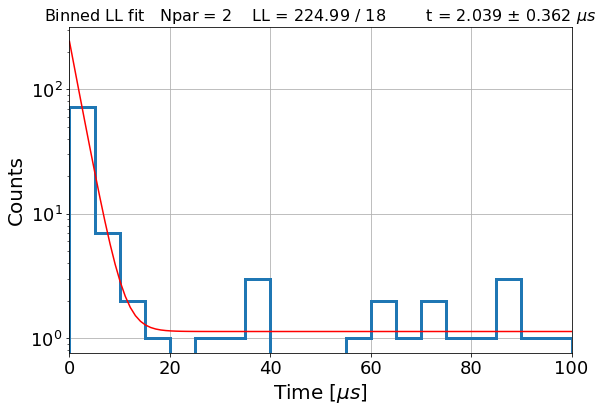

In [8]:
# Fitted dependence wraper

def myfit(fx, fpar):
    
    tdec = fpar[0]
    fdec = fpar[1]

    # Exponential probability distribution
    
    fval = fdec/tdec * np.exp(-fx/tdec)

    # Add constant term
    
    fval += (1-fdec)/tmax
    
    # Use global normalization
    
    return norm*fval


Nf = 100
xfun = np.linspace(0.,tmax,Nf)
yfun = myfit(xfun,par)

plt.figure(figsize=(9, 6))

plt.hist(ttab,range=[0,tmax],bins=Nbin,log=True, histtype='step',linewidth=3)
plt.plot(xfun,yfun,'r-')
plt.xlim([0,tmax])

plt.title('Binned LL fit   Npar = {}    LL = {:.2f} / {}        t = {:.3f} $\pm$ {:.3f} $\mu s$'.format(Nfun,logl,xvec.size-Nfun,par[0],epar[0]),size=16)
plt.ylabel('Counts',size=20)
plt.xlabel('Time [$\mu s$]',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')


fname = '11_shape_fit_'+str(Nevt)+'_'+str(Nbin)+'.png'
plt.savefig(fname)